In [1]:
from google.colab import files
import zipfile

# Upload the zip files
uploaded_files = files.upload()

# Extract the zip files
for zip_file in uploaded_files.keys():
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()

# List the contents of the current directory
!ls


Saving dataset.zip to dataset.zip
all  dataset.zip  must	never  none  only  sample_data


In [1]:
!pip install resampy


In [2]:
import resampy

Epoch 1/50
21/21 - 1s - loss: 1.1286 - accuracy: 0.5994 - val_loss: 0.7425 - val_accuracy: 0.7774 - 1s/epoch - 56ms/step
Epoch 2/50
21/21 - 0s - loss: 0.6049 - accuracy: 0.8066 - val_loss: 0.5048 - val_accuracy: 0.8567 - 177ms/epoch - 8ms/step
Epoch 3/50
21/21 - 0s - loss: 0.4399 - accuracy: 0.8547 - val_loss: 0.4317 - val_accuracy: 0.8689 - 176ms/epoch - 8ms/step
Epoch 4/50
21/21 - 0s - loss: 0.3677 - accuracy: 0.8830 - val_loss: 0.3904 - val_accuracy: 0.8902 - 183ms/epoch - 9ms/step
Epoch 5/50
21/21 - 0s - loss: 0.3366 - accuracy: 0.8899 - val_loss: 0.3743 - val_accuracy: 0.8994 - 186ms/epoch - 9ms/step
Epoch 6/50
21/21 - 0s - loss: 0.2912 - accuracy: 0.9006 - val_loss: 0.3465 - val_accuracy: 0.8963 - 172ms/epoch - 8ms/step
Epoch 7/50
21/21 - 0s - loss: 0.2596 - accuracy: 0.9144 - val_loss: 0.3393 - val_accuracy: 0.9024 - 173ms/epoch - 8ms/step
Epoch 8/50
21/21 - 0s - loss: 0.2414 - accuracy: 0.9243 - val_loss: 0.3376 - val_accuracy: 0.9024 - 158ms/epoch - 8ms/step
Epoch 9/50
21/21 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 4ms/step - loss: 0.3670 - accuracy: 0.9329
Test Accuracy: 93.29%
11/11 [==============================] - 0s 4ms/step


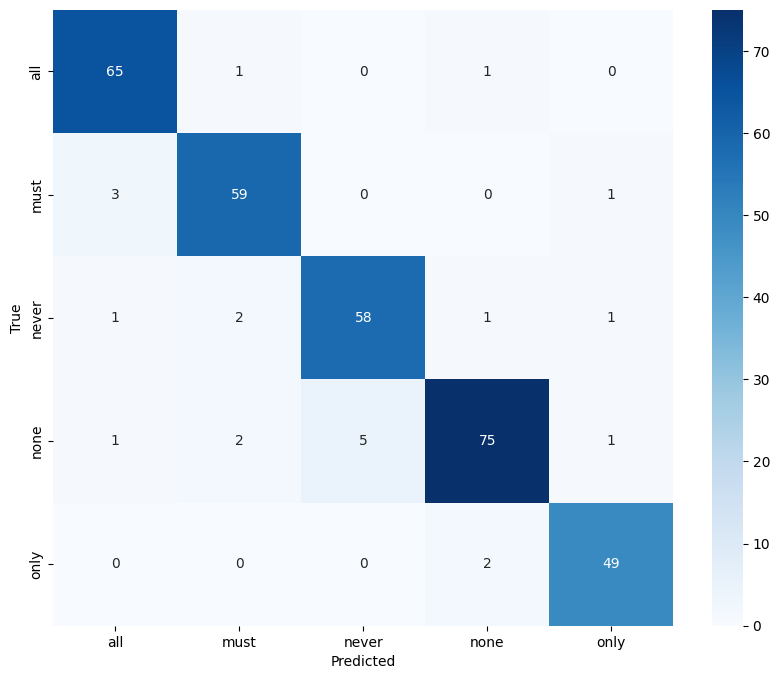

Total Raw Count in Confusion Matrix: 328


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import models, layers, optimizers
import os
import librosa
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow import lite

def extract_features(folder_path):
    features = []
    labels = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        audio, _ = librosa.load(file_path, res_type='kaiser_fast')

        # Extracting MFCC features
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=len(audio), n_mfcc=13), axis=1)
        features.append(mfccs)
        labels.append(folder_path.split('/')[-1])  # Assuming folder names are the labels

    return np.array(features), np.array(labels)

# Assuming your extracted folders are named 'all', 'none', 'never', 'must', and 'only'
folder_paths = ["all", "none", "never", "must", "only"]
all_features, all_labels = [], []

# Extract features from each folder
for folder_path in folder_paths:
    features, labels = extract_features(folder_path)
    all_features.append(features)
    all_labels.append(labels)

# Concatenate features and labels
X = np.vstack(all_features)
y = np.hstack(all_labels)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Build a simple neural network model
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Save the model
model.save('model.h5')

# Convert the model to TensorFlow Lite format
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('P6.tflite', 'wb') as f:
    f.write(tflite_model)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to original labels
y_test_orig = label_encoder.inverse_transform(y_test)
y_pred_orig = label_encoder.inverse_transform(y_pred_classes)

# Create a confusion matrix
conf_mat = confusion_matrix(y_test_orig, y_pred_orig, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Assuming you have the confusion matrix stored in 'conf_mat'
total_raw_count = np.sum(conf_mat)
print(f'Total Raw Count in Confusion Matrix: {total_raw_count}')